In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import time

import gdown
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import get_scorer
from dataheroes import CoresetTreeServiceDTC
from pathlib import Path
from tqdm.notebook import tqdm
encoding = "ISO-8859-1"
# surpress DeprecationWarning
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
MODEL_CLASS = xgb.XGBClassifier
SCORING = "f1"
scorer_f = get_scorer(scoring=SCORING)
pd.set_option("display.precision", 4)

In [4]:
xgb.__version__

'2.1.4'

### Data Preprocessing

#### Load Fraud Ecommerce Dataset
To view more information about the dataset please refer to the following <a href="https://www.kaggle.com/datasets/vbinh002/fraud-ecommerce"> link  </a>

In [7]:
# public folder on Google drive with data
url = "https://drive.google.com/drive/folders/1pLbSrTtTjZo_Ad3-FFMGwQpPeApfN3Vy"
# create local data folder
data_path = pathlib.Path("Fraud-Ecommerce")
data_path.mkdir(parents=True, exist_ok=True)
# download files
if not (data_path / "X_train.npy").exists():
    print("downloading folder")
    gdown.download_folder(url, quiet=True, use_cookies=False, output=str(data_path))

# load data to the memory
X_train = np.load(data_path / "X_train.npy")
y_train = np.load(data_path / "y_train.npy")
X_test = np.load(data_path / "X_test.npy")
y_test = np.load(data_path / "y_test.npy")

### Utility Functions

In [8]:
def evaluate_model(model):
    """
    Evaluate a model using the test set
    Parameters
    ----------
    model : object
        The model to evaluate
    Returns
    -------
    tuple
        The evaluation metrics
    """

    prediction = model.predict(X_test)
    prediction_proba = model.predict_proba(X_test)
    # compute scores
    balanced_acc = balanced_accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction_proba[:, 1], average="weighted")
    auprc = average_precision_score(y_test, prediction_proba[:, 1], average="weighted")
    log_loss_score = log_loss(y_test, prediction_proba[:, 1])
    return balanced_acc, f1, precision, recall, roc_auc, auprc, log_loss_score

## Data tuning

### Create a service with multiple trees

In [9]:
from dataheroes.data.common import DataParams

In [10]:
data_tuning_params = {
    "coreset_size": [0.3],
    "deterministic_size": [0.0, 0.1, 0.2],
    "class_size": [{1: 0.09}, {1: 0.11}, {1: 0.13},{1: 0.15}],
    "fair": [False],

}

In [11]:
service_obj = CoresetTreeServiceDTC(
    chunk_size = len(X_train) // 4,
    chunk_sample_ratio=1.0,
    data_tuning_params=data_tuning_params,
    model_cls=xgb.XGBClassifier,
)
service_obj.build(X_train, y_train)

2025-06-08 13:52:53 Build Started.
2025-06-08 13:52:54 Completed chunk #3, (chunk was built in 0.629 seconds)2025-06-08 13:52:54 Completed chunk #4, (chunk was built in 0.586 seconds)

2025-06-08 13:52:54 Completed chunk #1, (chunk was built in 0.731 seconds)
2025-06-08 13:52:54 Completed chunk #2, (chunk was built in 0.752 seconds)
2025-06-08 13:53:13 Build Completed in: 0:00:19.075.


In [12]:
# Print the number of trees
len(service_obj.trees) 

12

{0: None}

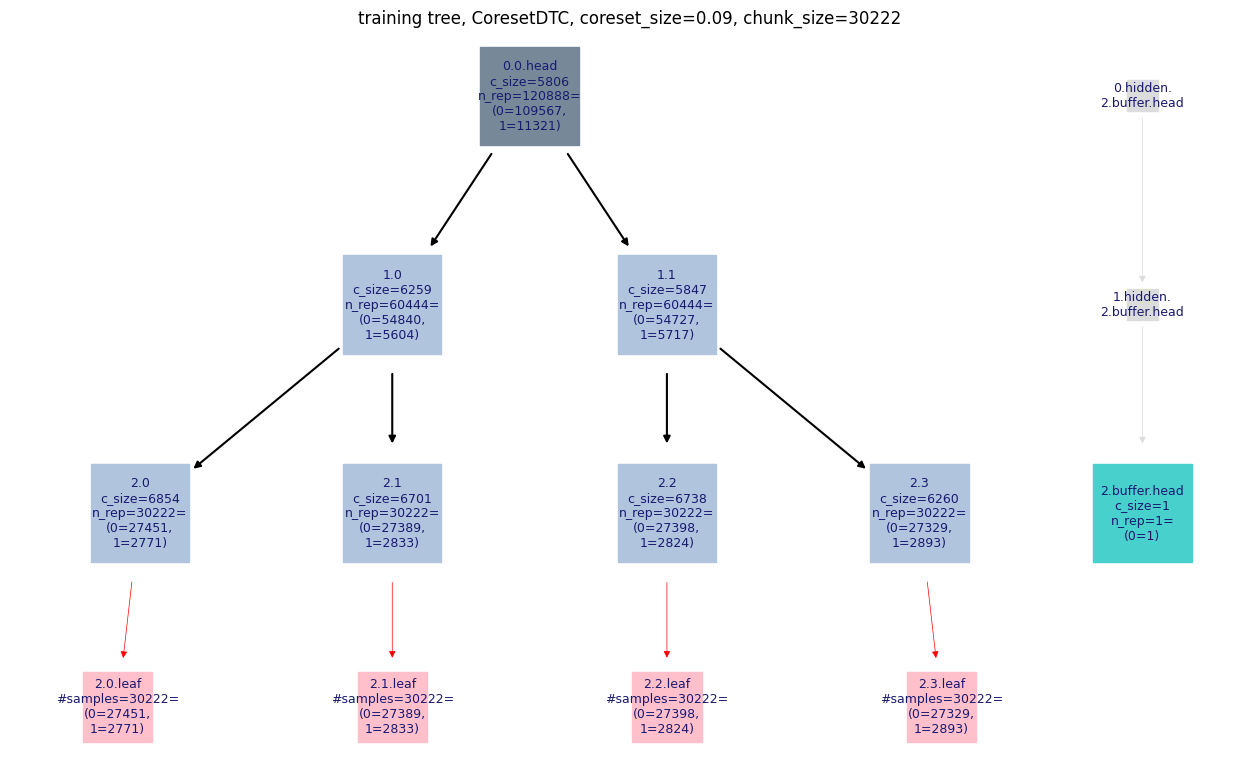

In [13]:
# Plotting the first tree, all trees have the same structure
service_obj.plot(tree_indices=[0])

### Run grid search on 1 tree

In [14]:
param_grid = {
    "learning_rate": [0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 150, 250],
    "max_depth": [4, 6, 8],
}

In [15]:
# Run grid search on 1 tree to search for a good model to do active sampling with.
model_params0, _, df_gs0, model0 = service_obj.grid_search(
    param_grid=param_grid, validation_method="cross validation", scoring=SCORING, tree_indices=[0]
)

In [19]:
df_gs0.sort_values(by="mean_folds_score", ascending=False)

,mean_folds_score,Fold 0,Fold 1,Fold 2,Fold 3,n_estimators,learning_rate,max_depth,tree_idx,coreset_size,det_weights_behaviour,deterministic_size,sample_all,class_size,fair
0,0.6803,0.6702,0.6907,0.6716,0.6886,100,0.05,4,0,0.3,keep,0.0,None,{1: 0.09},False
2,0.6801,0.6696,0.6907,0.6716,0.6886,150,0.05,4,0,0.3,keep,0.0,None,{1: 0.09},False
5,0.6800,0.6702,0.6897,0.6716,0.6885,250,0.05,4,0,0.3,keep,0.0,None,{1: 0.09},False
11,0.6799,0.6702,0.6897,0.6713,0.6885,150,0.10,4,0,0.3,keep,0.0,None,{1: 0.09},False
8,0.6799,0.6702,0.6895,0.6715,0.6885,100,0.10,4,0,0.3,keep,0.0,None,{1: 0.09},False
16,0.6777,0.6671,0.6872,0.6692,0.6874,250,0.10,4,0,0.3,keep,0.0,None,{1: 0.09},False
1,0.6776,0.6654,0.6906,0.6679,0.6863,100,0.05,6,0,0.3,keep,0.0,None,{1: 0.09},False
4,0.6774,0.6657,0.6906,0.6679,0.6853,150,0.05,6,0,0.3,keep,0.0,None,{1: 0.09},False
14,0.6774,0.6687,0.6860,0.6679,0.6870,100,0.20,4,0,0.3,keep,0.0,None,{1: 0.09},False
21,0.6768,0.6688,0.6848,0.6671,0.6864,150,0.20,4,0,0.3,keep,0.0,None,{1: 0.09},False


In [16]:
model_params0

{'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}

### Run Active Sample

In [20]:
# Run active sample with default xgb model
t_as = time.time()
best_tree, df_active_sample, model_as = service_obj.active_sample(
    model=MODEL_CLASS(**model_params0), scoring=SCORING, n_iter=5, perc_per_iter=0.04, patience=1, verbose=2
)
t_as = time.time() - t_as
print(f"Active Sample ran for {t_as:.4f}s")

Performing active sample on 12 trees.
Tree: 0, Initial validation score: 0.6801321489475762
Tree: 0, Iteration: 1/5, Node: 0. Added samples per class: {0: 1333, 1: 116}
Tree: 0, Iteration: 1/5, Node: 1. Added samples per class: {0: 1323, 1: 126}
Tree: 0, Iteration: 1/5, Node: 2. Added samples per class: {0: 1326, 1: 123}
Tree: 0, Iteration: 1/5, Node: 3. Added samples per class: {0: 1317, 1: 132}
Tree: 0, Iteration: 1/5, Average validation score before sampling: 0.6925687586347649
Tree 0: Finished iteration 1/5 in 10.56 seconds
Tree: 0, Iteration: 2/5, Node: 0. Added samples per class: {0: 1333, 1: 116}
Tree: 0, Iteration: 2/5, Node: 1. Added samples per class: {0: 1323, 1: 126}
Tree: 0, Iteration: 2/5, Node: 2. Added samples per class: {0: 1326, 1: 123}
Tree: 0, Iteration: 2/5, Node: 3. Added samples per class: {0: 1317, 1: 132}
Tree: 0, Iteration: 2/5, Average validation score before sampling: 0.6920448014574415
Early stopping due to no improvements over the best score for 1 iteratio

In [21]:
best_tree

10

In [22]:
df_active_sample.sort_values(by="fold_avg", ascending=False)

,tree_index,iter,fold_avg,fold0,fold1,fold2,fold3
31,10,1,0.6931,0.6828,0.7043,0.6865,0.6989
34,11,1,0.6931,0.6828,0.7043,0.6865,0.6989
22,7,1,0.6930,0.6827,0.7043,0.6867,0.6985
19,6,1,0.6930,0.6828,0.7043,0.6862,0.6988
25,8,1,0.6929,0.6822,0.7043,0.6865,0.6988
16,5,1,0.6929,0.6824,0.7043,0.6862,0.6988
28,9,1,0.6929,0.6828,0.7037,0.6865,0.6985
13,4,1,0.6928,0.6825,0.7037,0.6862,0.6988
10,3,1,0.6927,0.6822,0.7037,0.6864,0.6985
4,1,1,0.6926,0.6825,0.7037,0.6853,0.6988


### Train a model on the full dataset

In [23]:
t_full = time.time()
model_full = MODEL_CLASS(**model_params0).fit(X=X_train, y=y_train)
t_full = time.time() - t_full
print(f"Training on the full dataset ran in {t_full:.4f}s")

Training on the full dataset ran in 7.6363s


In [24]:
print(f"{scorer_f(model_full, X_test, y_test):.4f}")

0.6950


In [25]:
stats = {}
stats["Full_data"] = evaluate_model(model_full)
stats["Full_data"] += (t_full,)
stats["Active_sample"] = evaluate_model(model_as)
stats["Active_sample"] += (t_as,)
stats_df = pd.DataFrame(stats).T
stats_df.columns = ["Balanced accuracy", "F1", "Precision", "Recall", "ROC AUC", "AUPRC", "Log loss", "Time"]

stats_df

,Balanced accuracy,F1,Precision,Recall,ROC AUC,AUPRC,Log loss,Time
Full_data,0.7731,0.6950,0.9453,0.5495,0.7773,0.6223,0.1835,7.6363
Active_sample,0.7741,0.7052,0.9854,0.5491,0.7681,0.6286,0.1788,561.9514


### Grid search with model params

In [30]:
# Pick the best 3 trees
best_trees = []
for row_idx in df_active_sample["fold_avg"].sort_values(ascending=False).index:
    tree_idx = df_active_sample.loc[row_idx, "tree_index"]
    if tree_idx not in best_trees:
        best_trees.append(int(tree_idx))
    if len(best_trees) == 3:
        break
print(best_trees)

[10, 11, 7]


In [31]:
# Get the best trees and print their data tuning parameters
service_obj.trees_data_tuning_params(as_df=True).loc[best_trees]

,coreset_size,det_weights_behaviour,deterministic_size,sample_all,class_size,fair
10,0.3,keep,0.1,None,{1: 0.15},False
11,0.3,keep,0.2,None,{1: 0.15},False
7,0.3,keep,0.1,None,{1: 0.13},False


In [32]:
t_gs = time.time()
best_model_params, best_tree, df_all_runs, best_model = service_obj.grid_search(
    param_grid=param_grid, validation_method="cross validation", scoring=SCORING, tree_indices=best_trees
)
t_gs = time.time() - t_gs
print(f"Grid search on {len(best_trees)} trees ran in {t_gs:.4f}s")

Grid search on 3 trees ran in 1005.4424s


In [33]:
df_all_runs.sort_values(by = "mean_folds_score", ascending = False)

,mean_folds_score,Fold 0,Fold 1,Fold 2,Fold 3,n_estimators,learning_rate,max_depth,tree_idx,coreset_size,det_weights_behaviour,deterministic_size,sample_all,class_size,fair
44,0.6932,0.6830,0.7043,0.6865,0.6989,100,0.10,4,11,0.3,keep,0.2,None,{1: 0.15},False
47,0.6932,0.6830,0.7043,0.6865,0.6989,150,0.10,4,11,0.3,keep,0.2,None,{1: 0.15},False
0,0.6931,0.6828,0.7043,0.6865,0.6989,100,0.05,4,10,0.3,keep,0.1,None,{1: 0.15},False
12,0.6931,0.6828,0.7043,0.6865,0.6989,150,0.10,4,10,0.3,keep,0.1,None,{1: 0.15},False
38,0.6931,0.6828,0.7043,0.6865,0.6989,150,0.05,4,11,0.3,keep,0.2,None,{1: 0.15},False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,0.6834,0.6724,0.6930,0.6770,0.6911,250,0.30,6,10,0.3,keep,0.1,None,{1: 0.15},False
107,0.6833,0.6719,0.6943,0.6756,0.6912,250,0.30,8,7,0.3,keep,0.1,None,{1: 0.13},False
35,0.6832,0.6708,0.6959,0.6756,0.6904,250,0.30,8,10,0.3,keep,0.1,None,{1: 0.15},False
106,0.6825,0.6702,0.6957,0.6755,0.6887,250,0.30,6,7,0.3,keep,0.1,None,{1: 0.13},False


In [34]:
# Query the df with all runs for the best run
query_str = " and ".join(f"{col} == {val}" for col, val in best_model_params.items())
query_str += f" and tree_idx == {best_tree}"

df_best = df_all_runs.query(query_str)
df_best

,mean_folds_score,Fold 0,Fold 1,Fold 2,Fold 3,n_estimators,learning_rate,max_depth,tree_idx,coreset_size,det_weights_behaviour,deterministic_size,sample_all,class_size,fair
44,0.6932,0.683,0.7043,0.6865,0.6989,100,0.1,4,11,0.3,keep,0.2,None,{1: 0.15},False


In [35]:
print(f"{scorer_f(best_model, X_test, y_test):.4f}")

0.7052


### Full model grid search

In [36]:
model_full_gs = GridSearchCV(estimator=MODEL_CLASS(), param_grid=param_grid, cv=4, scoring=SCORING, verbose=1)

In [37]:
t_gs_full = time.time()
model_full_gs.fit(X_train, y_train)
t_gs_full = time.time() - t_gs_full
print(f"Grid search on the full dataset ran in {t_gs_full:.4f}s")

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Grid search on the full dataset ran in 1147.0324s


In [38]:
# Look at some statistics from GridSearchCV.
cols = ["mean_test_score"] + [s for s in model_full_gs.cv_results_.keys() if s.startswith("split")]
df_params_full = pd.DataFrame(model_full_gs.cv_results_["params"])
df_gs_full = pd.concat([pd.DataFrame(model_full_gs.cv_results_)[cols], df_params_full], axis=1)

# Get best score and pretty print it
df_gs_full.sort_values(by="mean_test_score", ascending=False).iloc[0].to_frame().T

,mean_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,learning_rate,max_depth,n_estimators
25,0.6833,0.6719,0.6987,0.6731,0.6896,0.2,8.0,150.0


In [39]:
stats["Full_data_gs"] = evaluate_model(model_full_gs)
stats["Full_data_gs"] += (t_gs_full,)
stats["Active_sample_gs"] = evaluate_model(best_model)
stats["Active_sample_gs"] += (t_gs,)
stats_df = pd.DataFrame(stats).T
stats_df.columns = ["Balanced accuracy", "F1", "Precision", "Recall", "ROC AUC", "AUPRC", "Log loss", "Time"]

stats_df

,Balanced accuracy,F1,Precision,Recall,ROC AUC,AUPRC,Log loss,Time
Full_data,0.7731,0.6950,0.9453,0.5495,0.7773,0.6223,0.1835,7.6363
Active_sample,0.7741,0.7052,0.9854,0.5491,0.7681,0.6286,0.1788,561.9514
Full_data_gs,0.7733,0.6964,0.9505,0.5495,0.7689,0.6264,0.1883,1147.0324
Active_sample_gs,0.7741,0.7052,0.9854,0.5491,0.7718,0.6308,0.1792,1005.4424
